In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, mean_squared_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import sys
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
data= pd.read_csv('student-por.csv', sep= ';')
data.shape
data.head()

(649, 33)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [3]:
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,
                         "No of Levels":data.apply(lambda x: x.nunique(),axis=0), 
                         "Levels":data.apply(lambda x: str(x.unique()),axis=0),
                         "Na's" : data.apply(lambda x: x.isna().sum())})
inspect_data(data)

,Data Type,No of Levels,Levels,Na's
school,object,2,['GP' 'MS'],0
sex,object,2,['F' 'M'],0
age,int64,8,[18 17 15 16 19 22 20 21],0
address,object,2,['U' 'R'],0
famsize,object,2,['GT3' 'LE3'],0
Pstatus,object,2,['A' 'T'],0
Medu,int64,5,[4 1 3 2 0],0
Fedu,int64,5,[4 1 2 3 0],0
Mjob,object,5,['at_home' 'health' 'other' 'services' 'teacher'],0
Fjob,object,5,['teacher' 'other' 'services' 'health' 'at_home'],0


In [4]:
for col in ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    data[col]= data[col].apply(lambda x: 1 if x== 'yes' else 0)

data['famsize']= data['famsize'].map({'GT3': 1, 'LE3': 0})

data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,1,A,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,1,T,1,1,at_home,other,course,father,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,0,T,1,1,at_home,other,other,mother,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,1,T,4,2,health,services,home,mother,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,1,T,3,3,other,other,home,father,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13


# Feature Engineering

In [5]:
# 1. Grades

# 1a. Difference between G1 and G2 exams (To caputre info about change in performance over time.)
data['G2-G1']= data['G2']- data['G1']

# 1b. Did the student get the same score in G1 & G2 exams?
data['isSameG12']= data['G2-G1'].apply(lambda d: 1 if d==0 else 0)
data['isSameG12'].value_counts()

# Parents Education

# 2a. Total parent's education 
data['tot_Pedu']= data['Medu'] + data['Fedu']

# 2b. Average parent's education
data['avg_Pedu']= (data['Medu'] + data['Fedu'])/2

# 2c. Impact of difference in the magnitude of parents' educational level.
data['diff_Pedu']= abs(data['Medu'] - data['Fedu'])

# 2d. Do Parents have equal educational level?
data['Same Education']= data[['Medu', 'Fedu']].apply(lambda j: 1 if j[0]== j[1] else 0, axis= 1)
data['Same Education'].value_counts()

# Parents' Jobs

# 3a. Is the mother at_home?
data['Mworking']= data['Mjob'].apply(lambda job: 0 if job== 'at_home' else 1)

# 3b. Is the father at_home?
data['Fworking']= data['Fjob'].apply(lambda job: 0 if job== 'at_home' else 1)
data['Mworking'].value_counts()
data['Fworking'].value_counts()

# 4. Are Parents Jobs in the Same Sector?
data['isSameSector']= data[['Mjob', 'Fjob']].apply(lambda j: 1 if j[0]== j[1] else 0, axis= 1)
data['isSameSector'].value_counts()

data.head()

0    460
1    189
Name: isSameG12, dtype: int64

1    343
0    306
Name: Same Education, dtype: int64

1    514
0    135
Name: Mworking, dtype: int64

1    607
0     42
Name: Fworking, dtype: int64

0    364
1    285
Name: isSameSector, dtype: int64

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G2-G1,isSameG12,tot_Pedu,avg_Pedu,diff_Pedu,Same Education,Mworking,Fworking,isSameSector
0,GP,F,18,U,1,A,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,11,0,8,4.0,0,1,0,1,0
1,GP,F,17,U,1,T,1,1,at_home,other,course,father,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11,2,0,2,1.0,0,1,0,1,0
2,GP,F,15,U,0,T,1,1,at_home,other,other,mother,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12,1,0,2,1.0,0,1,0,1,0
3,GP,F,15,U,1,T,4,2,health,services,home,mother,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14,0,1,6,3.0,2,0,1,1,0
4,GP,F,16,U,1,T,3,3,other,other,home,father,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13,2,0,6,3.0,0,1,1,1,1


#### Memory Optimisation

In [6]:
currentTrainMem = data.memory_usage().sum()
print('Current memory usage', currentTrainMem)

obj_cols= data.select_dtypes(include= 'object').columns
num_cols= data.select_dtypes(include= 'number').columns

data[obj_cols]= data[obj_cols].astype('category')
data[num_cols]= data[num_cols].astype('int8')  # All numeric cols are below 128.

newTrainMem = data.memory_usage().sum()
print('Memory usage after conversions', newTrainMem)
print('memory saved: ', "{0:.2f}".format((1- newTrainMem/currentTrainMem) * 100),'%')

Current memory usage 218192
Memory usage after conversions 28466
memory saved:  86.95 %


In [7]:
from sklearn.model_selection import train_test_split
target= 'G3'
X_train, X_test, y_train, y_test = train_test_split(data.loc[ : , data.columns != target], 
                                                  data[target], 
                                                  test_size = 0.25, 
                                                  random_state=42)

X_train.reset_index(drop= True, inplace= True)
y_train.reset_index(drop= True, inplace= True)

X_test.reset_index(drop= True, inplace= True)
y_test.reset_index(drop= True, inplace= True)

data= None

X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G2-G1,isSameG12,tot_Pedu,avg_Pedu,diff_Pedu,Same Education,Mworking,Fworking,isSameSector
0,GP,F,16,U,0,T,4,4,teacher,teacher,reputation,mother,1,2,0,0,1,0,0,1,1,1,0,4,5,2,1,2,3,0,11,10,-1,0,8,4,0,1,1,1,1
1,GP,M,15,U,1,T,2,2,services,services,course,father,1,1,0,1,1,0,0,1,1,1,0,5,4,1,1,1,1,0,9,10,1,0,4,2,0,1,1,1,1
2,GP,M,15,U,1,T,4,4,services,teacher,course,father,1,2,0,0,1,0,1,1,1,1,0,4,3,3,1,1,5,0,14,15,1,0,8,4,0,1,1,1,0
3,GP,M,16,U,1,T,3,1,other,other,reputation,mother,1,1,0,0,0,0,1,1,1,0,0,5,3,2,2,2,5,0,13,13,0,1,4,2,2,0,1,1,1
4,MS,F,16,R,0,T,1,2,at_home,other,course,mother,1,2,0,0,0,0,1,1,0,1,0,4,4,5,1,3,3,0,8,9,1,0,3,1,1,0,0,1,0


# Pre-Processing

Skewedness affects algorithms such as Linear Regression that assume linearity of the data.

In [8]:
def getSkew(X):

    skewed_cols= 0
    num_cols= X.select_dtypes(include= 'number').columns
    for col in num_cols:
    
        skew= X[col].skew()
        if abs(skew) > 1:
            print(col, ':', skew)
            skewed_cols+=1
        
    print('\n', skewed_cols, 'features are significantly skewed.')
    
getSkew(X_train)

traveltime : 1.2702279393089093
failures : 2.951990831935312
schoolsup : 2.622422727839202
paid : 3.5119892481863615
nursery : -1.4759207897483908
higher : -2.4496921324203678
internet : -1.164647104346785
famrel : -1.1407182158314515
Dalc : 2.0991445035758347
absences : 1.9035223032571347
diff_Pedu : 1.0720559436630797
Mworking : -1.3694603863518184
Fworking : -3.4457745714297077

 13 features are significantly skewed.


In [9]:
# Custom sklearn transformer to reduce skewedness of features using Box-Cox Transformations
'''
Features:
1. Accepts non-positive inputs
2. Skips features where the transformation hasn't reduced skewdness.
3. Can be fitted with a 2D array or a dataframe. 
4. Can be used individually & in sklearn pipelines.
'''

from sklearn.base import BaseEstimator, TransformerMixin
import scipy.stats as ss

class unskew(BaseEstimator, TransformerMixin):
    
    def toArr(self, X):
        return X.to_numpy() if isinstance(X, pd.DataFrame) else X
    
        
    def boxCoxTransform(self, X, col, lmbda= None):
        c=  0 if min(X[:, col]) > 0 else 1- min(X[:, col])
        
        return ss.boxcox(X[:, col] + c, lmbda= lmbda)
    
    def getLambda(self, X, col):
        
        X= self.toArr(X)    
        
        # boxcox returns [0]- transformed, [1]- lambda value  
        bc= self.boxCoxTransform(X, col)        
        lmbda= bc[1]
    
        # we only need the magnitude of the skew to compare
        originalSkew= abs(ss.skew(X[:, col]))
        bcSkew= abs(ss.skew(bc[0]))
    
        # return lambda if boxcox reduces the skew. Else return nan to indicate to not transform.    
        return lmbda if bcSkew < originalSkew else np.nan    
    

    def fit(self, X, y=None):
        
        X= self.toArr(X)
        
        lmbdas= []
        for i in range(X.shape[1]):
            lmbdas.append(self.getLambda(X, i))
    
        self.lambdas_= lmbdas
            
        return self

    def transform(self, X, y=None):
        
        X= self.toArr(X)

        for i in range(X.shape[1]):
            
            # transform only if the skew is reducing. Nan indicates that the skew increased after boxcox.
            if ~np.isnan(self.lambdas_[i]):
                X[:, i]= self.boxCoxTransform(X, i, lmbda= self.lambdas_[i])
              
        return X

    def fit_transform(self, X, y=None):

        self = self.fit(X)
        return self.transform(X, y)
    

class dummy(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):      
        return self

    def transform(self, X, y=None):
        return X

    def fit_transform(self, X, y=None):
        self = self.fit(X, y)
        return self.transform(X, y)

"\nFeatures:\n1. Accepts non-positive inputs\n2. Skips features where the transformation hasn't reduced skewdness.\n3. Can be fitted with a 2D array or a dataframe. \n4. Can be used individually & in sklearn pipelines.\n"

<br>
<b>Encoding:</b><br>
    1. Nominal features such as 'sex', 'reason' are encoded with a variant of Mean Target encoding.<br>
    2. Ordinal features such as 'traveltime', 'Fedu' etc. are left as Label encoded.

In [10]:
numCols = list(X_train.select_dtypes(include= 'number'))
catCols= list(X_train.select_dtypes(include= 'category'))

numeric_transformer = Pipeline(steps= [
    ('dummy', dummy())
])

categorical_transformer = Pipeline(steps=[
    ('enc', ce.LeaveOneOutEncoder(sigma= 0.2))   # LeaveOneOutEncoder excludes the current row's target value while calculating the target's mean. 
])                                               # This adds some variation to the data as well as said to be better at dealing with outliters.
                                                 # Sigma, adds slight noise only in train data but not test, is said to reduce overfitting.

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numCols),
    ('cat', categorical_transformer, catCols)
], n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Box-Cox', unskew()),
    ('MinMax', MinMaxScaler(feature_range=(0,1)))
])

X_train_enc= pd.DataFrame(pipeline.fit_transform(X_train, y_train), columns= numCols+catCols)
X_test_enc= pd.DataFrame(pipeline.fit_transform(X_test, y_test), columns= numCols+catCols)

X_train= None
X_test= None

X_train_enc.shape
X_train_enc.head()

(486, 41)

,age,famsize,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G2-G1,isSameG12,tot_Pedu,avg_Pedu,diff_Pedu,Same Education,Mworking,Fworking,isSameSector,school,sex,address,Pstatus,Mjob,Fjob,reason,guardian
0,0.211238,0.0,1.00,1.000000,0.0,0.491919,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.602598,1.000000,0.25,0.00000,0.451780,0.44427,0.0,0.568598,0.440480,0.40,0.0,1.000000,1.000000,0.000000,1.0,1.0,1.0,1.0,0.746895,0.859914,0.649485,0.619212,0.520907,0.668744,0.449004,0.265466
1,0.000000,1.0,0.50,0.590833,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.000000,0.735543,0.00,0.00000,0.000000,0.00000,0.0,0.452505,0.440480,0.50,0.0,0.581896,0.584076,0.000000,1.0,1.0,1.0,1.0,0.650219,0.440557,0.543906,0.428134,0.470405,0.422730,0.435021,0.419469
2,0.000000,1.0,1.00,1.000000,0.0,0.491919,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.602598,0.478802,0.50,0.00000,0.000000,1.00000,0.0,0.749174,0.737928,0.50,0.0,1.000000,1.000000,0.000000,1.0,1.0,1.0,0.0,0.806135,0.486573,0.506445,0.399209,0.710610,0.574800,0.614102,0.329647
3,0.211238,1.0,0.75,0.333716,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.000000,0.478802,0.25,0.85834,0.451780,1.00000,0.0,0.688196,0.614568,0.45,1.0,0.581896,0.584076,0.886176,0.0,1.0,1.0,1.0,0.737856,0.610810,0.000000,0.213912,0.419513,0.577385,0.520216,0.423563
4,0.211238,0.0,0.25,0.590833,0.0,0.491919,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.602598,0.735543,1.00,0.00000,0.700987,0.44427,0.0,0.395943,0.385697,0.50,0.0,0.460666,0.327089,0.661301,0.0,0.0,1.0,0.0,0.236617,0.548765,0.469505,0.555514,0.483871,0.180376,0.168566,0.750136


In [11]:
# Check skew after the transformation
getSkew(X_train_enc)

failures : 1.8556314530230877
schoolsup : 2.622422727839202
paid : 3.511989248186361
nursery : -1.4759207897483908
higher : -2.4496921324203678
internet : -1.164647104346785
Mworking : -1.3694603863518184
Fworking : -3.4457745714297077

 8 features are significantly skewed.


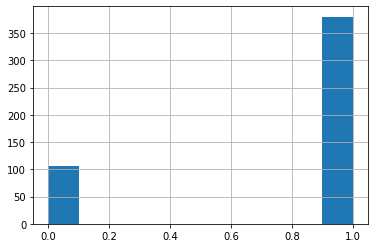

In [12]:
# Example:
X_train_enc['Mworking'].hist();

Box-Cox Transformation couldn't reduce skewedness of some features. These are mostly binary.

# Feature Selection (using Random Forest)

#### Hyperparameter tuning (using Baysian Optimisation)

In [13]:
# 3. Random Forest choses features randomly to buld several trees. Hence, it is a good algorithm to derive feature importances.

space = {
    'max_depth': hp.quniform('max_depth', 3, 5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),   
    # The goal is to encourage the algorightm to try out all features to determine their usefulness.
    # Therefore, the range of max_features is set to a higher value.
    'max_features': hp.quniform('max_features', 10, 30, 1),
}

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'max_features': int(params['max_features'])
    }

    # Perform n_fold cross validation with hyperparameters
    rf = RandomForestRegressor(**params, n_jobs= -1)
    skf = StratifiedKFold(n_splits= 8, shuffle= True, random_state = 42)
    scores = cross_val_score(rf, X_train_enc, y_train, cv= skf.split(X_train_enc, y_train), 
                             scoring= 'neg_root_mean_squared_error', n_jobs= -1).mean()
    return {'loss': -scores, 'params': params, 'status': STATUS_OK}

# Trials object to track progress
trials = Trials()
rf_best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 30, trials = trials)

100%|██████████| 30/30 [01:32<00:00,  3.09s/trial, best loss: 1.2840601703578858]


In [14]:
#rf_best
# best {'max_depth': 4.0, 'max_features': 24.0, 'n_estimators': 150.0}
rf= RandomForestRegressor(max_depth= 4, max_features= 24, n_estimators= 150, n_jobs= -1, random_state= 42)
rf.fit(X_train_enc, y_train)

pred_train_rf = rf.predict(X_train_enc)
pred_test_rf = rf.predict(X_test_enc)

from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, pred_train_rf))
np.sqrt(mean_squared_error(y_test, pred_test_rf))

RandomForestRegressor(max_depth=4, max_features=24, n_estimators=150, n_jobs=-1,
                      random_state=42)

1.0527773243963663

1.3601845774913606

In [15]:
importances = list(zip(rf.feature_importances_ * 100, X_train_enc.columns))
importances.sort(reverse= True)
print('Top 10 Important Features')
importances[:10]

Top 10 Important Features


[(61.926627786991496, 'G2'),
 (22.441298825563567, 'G1'),
 (4.407955274256174, 'G2-G1'),
 (3.524307505971934, 'failures'),
 (1.9051637156389813, 'absences'),
 (0.6190987463963371, 'address'),
 (0.5295436974056238, 'reason'),
 (0.4723567359962737, 'Fjob'),
 (0.4188596048997435, 'Mjob'),
 (0.37041821141823517, 'guardian')]

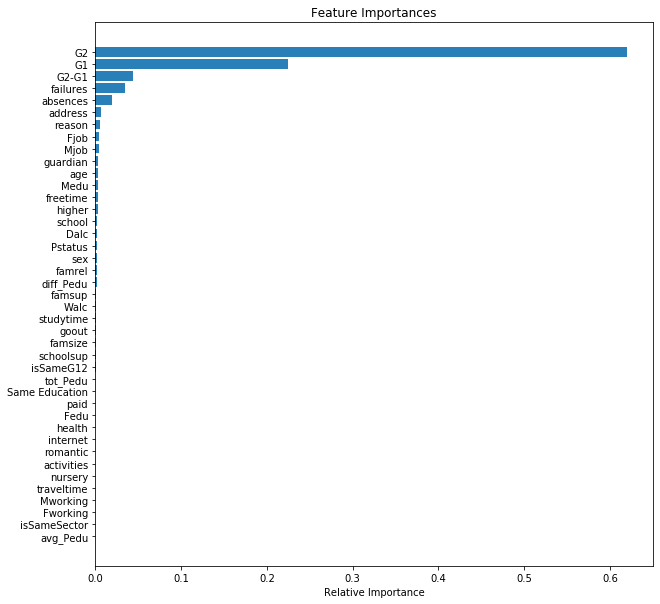

In [16]:
features = X_train_enc.columns
importances_ = rf.feature_importances_
indices = np.argsort(importances_)

f, ax= plt.subplots(figsize= (10, 10))
plt.title('Feature Importances');
plt.barh(range(len(indices)), importances_[indices], color='#2980b9', align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.xlabel('Relative Importance');

In [17]:
# Dropping features that were less than 1% imporant (heuristic)

del_cols= []
for x in importances:
    if x[0] <= 1.0:
        del_cols.append(x[1])
        
len(del_cols)

X_train_enc.drop(columns= del_cols, inplace= True)
X_test_enc.drop(columns= del_cols, inplace= True)
X_train_enc.head()

36

,failures,absences,G1,G2,G2-G1
0,0.0,0.0,0.568598,0.440480,0.40
1,0.0,0.0,0.452505,0.440480,0.50
2,0.0,0.0,0.749174,0.737928,0.50
3,0.0,0.0,0.688196,0.614568,0.45
4,0.0,0.0,0.395943,0.385697,0.50


## Multicollinearity

Detecting multicollinearity using:<br>
1. Correlation Matrix<br>
2. Variance Inflation Factor (VIF)<br>

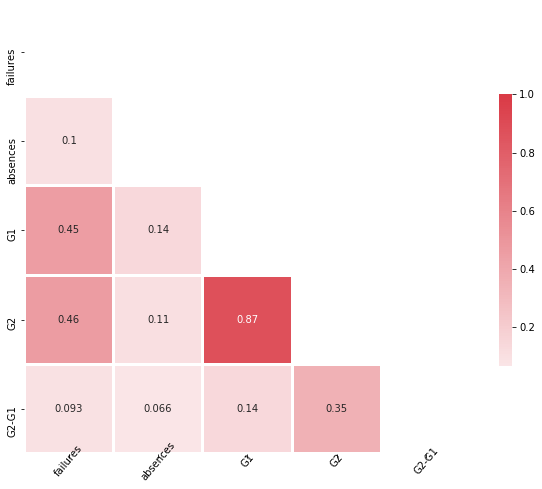

In [18]:
# 1. Correlation matrix

import seaborn as sns
# Compute the correlation matrix
corr = X_train_enc.corr()
corr_final = np.abs(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_final, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=2, cbar_kws={"shrink": .5})

plt.xticks(rotation=50, fontsize="10", va="center")
plt.show();

In [19]:
# 2. VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train_enc.values, i) for i in range(X_train_enc.shape[1])]
pd.DataFrame({'VIF': vif[0:]}, index= X_train_enc.columns).T

,failures,absences,G1,G2,G2-G1
VIF,1.499854,2.377723,53.587467,79.446965,20.083449


Observation:<br>
From the correlation matrix and the VIF, it can be seen that features have significant multicollinearity.

### Eleminating multi-collinearity using PCA

In [20]:
pca = PCA()
pca.fit(X_train_enc)
pca.explained_variance_ratio_.cumsum()

PCA()

array([0.53654416, 0.85132973, 0.9692462 , 0.99984338, 1.        ])

In [22]:
pca= PCA(n_components= 4, random_state= 42) 

X_train_enc_pca= pd.DataFrame(pca.fit_transform(X_train_enc))
X_test_enc_pca= pd.DataFrame(pca.transform(X_test_enc))

X_train_enc= None
X_test_enc= None

X_train_enc_pca.head()

,0,1,2,3
0,-0.192311,-0.301767,-0.152295,-0.067832
1,-0.165981,-0.299130,-0.223530,0.065170
2,-0.312871,-0.294042,0.169519,0.045607
3,-0.266090,-0.297474,0.044722,-0.014640
4,-0.138461,-0.300065,-0.297163,0.069663


# Model Building
1. Linear Regression
2. Elastic-Net Regression
3. Random Forest Regression

In [23]:
result= pd.DataFrame(columns=['Model','Train RMSE','Test RMSE'])
result

,Model,Train RMSE,Test RMSE


## 1. Linear Regression (in R)

In [24]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.0/Resources'

# activate R magic
%load_ext rpy2.ipython

In [25]:
%%R
library(glmnet)
library(Metrics)
library(DMwR)
set.seed(0)

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.0-2

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: grid

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [26]:
%%R -i X_train_enc_pca -i y_train -i X_test_enc_pca -i y_test -o train_rmse_lr -o test_rmse_lr

#X_train_r<- as.matrix(X_train_enc_pca)
X_train_r<- X_train_enc_pca
X_test_r<- X_test_enc_pca
y_train_r<- y_train
y_test_r<- y_test

lr<- lm(y_train_r~., data= X_train_r)

pred_train_elr<- predict(lr, X_train_r)
pred_test_elr<- predict(lr, X_test_r)  

# RMSE calculation
train_rmse_lr<- rmse(pred_train_elr, y_train_r)
test_rmse_lr<- rmse(pred_test_elr, y_test_r)

cat('Train RMSE: ', train_rmse_lr, '\n')
cat('Test RMSE: ', test_rmse_lr, '\n')
summary(lr)

Train RMSE:  1.315655 
Test RMSE:  1.214393 

Call:
lm(formula = y_train_r ~ ., data = X_train_r)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4621 -0.4986  0.0324  0.6617  5.9466 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.79630    0.05999 196.642  < 2e-16 ***
`0`         -4.92851    0.15463 -31.873  < 2e-16 ***
`1`          1.20337    0.20187   5.961 4.86e-09 ***
`2`         11.99773    0.32984  36.374  < 2e-16 ***
`3`          4.96036    0.64751   7.661 1.03e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.322 on 481 degrees of freedom
Multiple R-squared:  0.8349,	Adjusted R-squared:  0.8336 
F-statistic: 608.3 on 4 and 481 DF,  p-value: < 2.2e-16



<b>
1. The signif. codes of the features and the low p-value indicate that all features are significant.<br>
2. Adjusted R-squared values is ~83%--which is a good value.</b>

### Residual Analysis

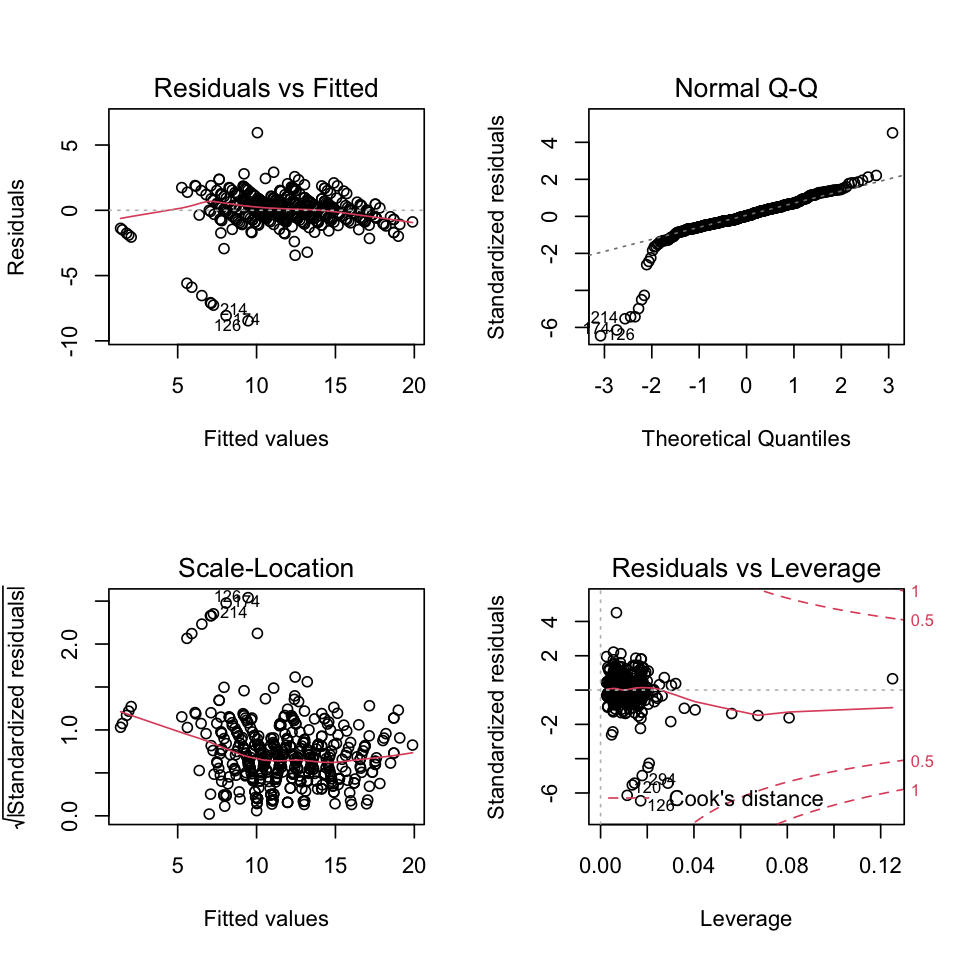

In [27]:
%%R -w 6 -h 6 --units in -r 160
par(mfrow=c(2,2))
plot(lr)

<b>
1. Residual vs Fitted:<br>
</b>
The residuals mostly have no pattern. Hence the relationship is linear.<br>
<br>
<b>
2. QQ Plot:
</b><br>
The distribution is not entirely normal<br>
<br>
<b>
3. Scale-Location:
</b><br>
Residuals are homoscedastic.<br>
<br><b>
4. Cook's Distance:
</b><br>
There are no outliers.
<br><br>
The assumptions are mostly in-line. However, the assumption of normality has been considerably violated. Therefore, the other models are explored.

In [28]:
result.loc[len(result)] = ['Linear Regression', train_rmse_lr[0], test_rmse_lr[0]]

## 2. Elastic-Net Regression

In [29]:
def bestRatioELR(X, y):
    best_ratio= None
    best_rmse= 1000.0
    
    for l1_ratio in np.arange(0.1, 1.1, 0.1):    
        elr= ElasticNetCV(l1_ratio= l1_ratio, random_state= 42)
        elr.fit(X, y)
        pred = elr.predict(X)
        rmse= np.sqrt(mean_squared_error(y, pred))
    
        if best_rmse > rmse:
            best_ratio= l1_ratio
            best_rmse= rmse
        
    print('best_ratio:', best_ratio)
    return best_ratio

In [30]:
elr= ElasticNetCV(l1_ratio= bestRatioELR(X_train_enc_pca, y_train), random_state= 0)
elr.fit(X_train_enc_pca, y_train)
pred_train_elr = elr.predict(X_train_enc_pca)
pred_test_elr = elr.predict(X_test_enc_pca)

train_rmse_elr= np.sqrt(mean_squared_error(y_train, pred_train_elr))
test_rmse_elr= np.sqrt(mean_squared_error(y_test, pred_test_elr))

best_ratio: 1.0


ElasticNetCV(l1_ratio=1.0, random_state=0)

We see that Lasso is the best choice

In [31]:
result.loc[len(result)] = ['ELR Regression', train_rmse_elr, test_rmse_elr]

print('Train RMSE:', train_rmse_elr)
print('Test RMSE:', test_rmse_elr)

print('\nCoefficients: ', elr.coef_)

Train RMSE: 1.315689579100572
Test RMSE: 1.2115804896522122

Coefficients:  [-4.92358004  1.19496794 11.97530122  4.87393777]


## 3. Random Forest

In [32]:
# 3. Random Forest

space = {
    'max_depth': hp.quniform('max_depth', 4, 5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 300, 5),
    'max_features': hp.quniform('max_features', 2, X_train_enc_pca.shape[1], 1),
}

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'max_features': int(params['max_features'])
    }

    # Perform n_fold cross validation with hyperparameters
    rf = RandomForestRegressor(**params, n_jobs= -1)
    skf = StratifiedKFold(n_splits= 10, shuffle= True, random_state = 42)
    scores = cross_val_score(rf, X_train_enc_pca, y_train, 
                             cv= skf.split(X_train_enc_pca, y_train), scoring= 'neg_root_mean_squared_error', n_jobs= -1).mean()
    return {'loss': -scores, 'params': params, 'status': STATUS_OK}

# Trials object to track progress
trials = Trials()
rf_best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 30, trials = trials)

100%|██████████| 30/30 [01:26<00:00,  2.87s/trial, best loss: 1.3902553161861397]


In [33]:
# Best features are {'max_depth': 5.0, 'max_features': 3.0, 'n_estimators': 265.0}

rf= RandomForestRegressor(max_depth= 5, max_features= 3, n_estimators= 265, n_jobs= -1, random_state = 42)
rf.fit(X_train_enc_pca, y_train)

pred_train_rf = rf.predict(X_train_enc_pca)
pred_test_rf = rf.predict(X_test_enc_pca)

train_rmse_rf= np.sqrt(mean_squared_error(y_train, pred_train_rf))
test_rmse_rf= np.sqrt(mean_squared_error(y_test, pred_test_rf))

print('\nTrain RMSE:', train_rmse_rf)
print('Test RMSE:', test_rmse_rf)

RandomForestRegressor(max_depth=5, max_features=3, n_estimators=265, n_jobs=-1,
                      random_state=42)


Train RMSE: 1.0388265821827545
Test RMSE: 1.1818459880008383


Feature Importances in %: [43.6746025  18.06715648 34.99044042  3.26780059] 



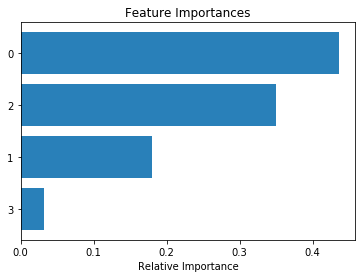

In [34]:
features = X_train_enc_pca.columns
importances_ = rf.feature_importances_
indices = np.argsort(importances_)

print('Feature Importances in %:', importances_*100, '\n');

plt.title('Feature Importances');
plt.barh(range(len(indices)), importances_[indices], color='#2980b9', align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.xlabel('Relative Importance');

In [36]:
result.loc[len(result)] = ['Random Forest', train_rmse_rf, test_rmse_rf]

# Model Selection

In [37]:
result

,Model,Train RMSE,Test RMSE
0,Linear Regression,1.315655,1.214393
1,ELR Regression,1.315690,1.211580
2,Random Forest,1.038827,1.181846


Occam's Razor is followed for model selection. Therefore, when multiple models show similar performance, the simpler one is preferred. Here, all three models have similar test RMSE. 
<br><b>Therefore, Linear Regression model is selected for production.</b>